In [1]:
# help function
from transfer_learning import NeuralNet
from dataset_loader import data_loader, all_filter, get_descriptors, one_filter, data_scaler

# modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import os, sys
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from tqdm import tqdm
from scipy.stats import pearsonr

import matplotlib.pyplot as plt 

# file name and data path
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_path = os.getcwd()
file_name = 'data/CrystGrowthDesign_SI.csv'

"""
Data description.

    Descriptors:
        'void fraction', 'Vol. S.A.', 'Grav. S.A.', 'Pore diameter Limiting', 'Pore diameter Largest'
    Source task:
        'H2@100 bar/243K (wt%)'
    Target tasks:
        'H2@100 bar/130K (wt%)' 'CH4@100 bar/298 K (mg/g)' '5 bar Xe mol/kg' '5 bar Kr mol/kg'
"""

descriptor_columns = ['void fraction', 'Vol. S.A.', 'Grav. S.A.', 'Pore diameter Limiting', 'Pore diameter Largest']
one_filter_columns = ['H2@100 bar/243K (wt%)'] 
another_filter_columns = ['H2@100 bar/130K (wt%)'] 

# load data
data = data_loader(base_path, file_name)
data=data.reset_index(drop=True)
# extract descriptors and gas adsorptions
one_property = one_filter(data, one_filter_columns)
descriptors = get_descriptors(data, descriptor_columns)

# prepare training inputs and outputs
X = np.array(descriptors.values, dtype=np.float32)
y = np.array(one_property.values, dtype=np.float32).reshape(len(X), )

X = data_scaler(X)
y = data_scaler(y.reshape(-1, 1)).reshape(len(X),)
epochs=1000
## hyper-parameters

seeds = np.arange(epochs)
Ns = list()
scores_epochs = list()
scores_test = list()
scores_train = list()

pred_tests = list()
grt_train_X = list()
grt_test_X = list()
grt_tests = list()
nsamples=100

input_size = 6
hidden_size_1 = 128
hidden_size_2 = 64
output_size = 1
learning_rate = .0002


model = NeuralNet(input_size, hidden_size_1, hidden_size_2, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

from Statistics_helper import stratified_cluster_sample
df,t_1,t_2,y_1,y_2=stratified_cluster_sample(1,data,descriptor_columns,one_filter_columns[0],5,net_out=True)
df=df[0]
#df=df.drop("Cluster",axis=1)
interest=one_filter_columns[0]
descriptor_columns.append("Cluster")
features=descriptor_columns
from transfer_learning import MyDataset
df_train,df_val,y_df_train,y_df_val = train_test_split(df[features],df[interest],test_size=.1)
df_train[interest]=np.array(y_df_train)
df_val[interest]=(np.array(y_df_val))
first=MyDataset(df_train,interest,features)
train_loader= torch.utils.data.DataLoader(first,batch_size=512)
second=MyDataset(df_val,interest,features)
val_loader = torch.utils.data.DataLoader(second,batch_size=len(df_val))



In [9]:
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, MeanSquaredError
from ignite.contrib.metrics.regression import R2Score
#declared model above
def train_step(engine, batch):
    x, y = batch
    model.train()
    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

    return loss.item()

trainer = Engine(train_step)

@trainer.on(Events.EPOCH_COMPLETED(every=1))
def log_training(engine):
    batch_loss = engine.state.output
    lr = optimizer.param_groups[0]['lr']
    e = engine.state.epoch
    n = engine.state.max_epochs
    i = engine.state.iteration
    print(f"Epoch {e}/{n} : {i} - batch loss: {batch_loss}, lr: {lr}")


#trainer.run(train_loader, max_epochs=5)

Epoch 1/5 : 95 - batch loss: 0.008189274929463863, lr: 0.0002
Epoch 2/5 : 190 - batch loss: 0.008188989944756031, lr: 0.0002
Epoch 3/5 : 285 - batch loss: 0.008195686154067516, lr: 0.0002
Epoch 4/5 : 380 - batch loss: 0.008184026926755905, lr: 0.0002
Epoch 5/5 : 475 - batch loss: 0.00818193331360817, lr: 0.0002


State:
	iteration: 475
	epoch: 5
	epoch_length: 95
	max_epochs: 5
	output: 0.00818193331360817
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [45]:
import time
from torchvision.transforms import Compose, Normalize, ToTensor
from ignite.engine import Events, create_supervised_evaluator, create_supervised_trainer
from ignite.handlers import Checkpoint
from ignite.metrics import Accuracy, Loss
from ignite.utils import setup_logger
from ignite.utils import setup_logger
from ignite.contrib.handlers.clearml_logger import (
    ClearMLLogger,
    ClearMLSaver,
    GradsHistHandler,
    GradsScalarHandler,
    WeightsHistHandler,
    WeightsScalarHandler,
    global_step_from_engine,
)

train_loss=[]
train_r_2=[]
val_loss=[]
val_r_2=[]

epochs=10
batch_size=128
store_loss=[]
store_time=[]
start=time.time()
model = NeuralNet(input_size, hidden_size_1, hidden_size_2, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
trainer = Engine(train_step)
#trainer.logger = setup_logger("Trainer")
@trainer.on(Events.EPOCH_COMPLETED(every=10))
def log_training(engine):
    batch_loss = engine.state.output
    lr = optimizer.param_groups[0]['lr']
    e = engine.state.epoch
    n = engine.state.max_epochs
    i = engine.state.iteration
    #print(f"Epoch {e}/{n} : {i} - batch loss: {batch_loss}, lr: {lr}")
metrics = {"loss": Loss(criterion),"r_2" : R2Score()}

train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
#train_evaluator.logger = setup_logger("Train Evaluator")
validation_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
#validation_evaluator.logger = setup_logger("Val Evaluator")

@trainer.on(Events.EPOCH_COMPLETED)
def store_metrics(engine):
    train_evaluator.run(train_loader)
    validation_evaluator.run(val_loader)
    out=train_evaluator.state.metrics
    out_2=validation_evaluator.state.metrics
    train_loss.append(out["loss"])
    train_r_2.append(out["r_2"])
    val_loss.append(out_2["loss"])
    val_r_2.append(out_2["r_2"])

train_loader= torch.utils.data.DataLoader(first,batch_size=batch_size)
trainer.run(train_loader, max_epochs=epochs)

State:
	iteration: 950
	epoch: 10
	epoch_length: 95
	max_epochs: 10
	output: 0.5943852066993713
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [55]:
dic={"train_loss": train_loss,"train_r_2": train_r_2,"val_loss": val_loss,"val_r_2": val_r_2}
case_metrics=pd.DataFrame.from_dict(dic)
case_metrics.to_json("Here.json")

In [56]:
pd.read_json("Here.json")

,train_loss,train_r_2,val_loss,val_r_2
0,18.448972,-0.557269,18.511771,-0.609207
1,4.455994,0.623872,4.553440,0.604175
2,1.469734,0.875940,1.604155,0.860553
3,0.930306,0.921473,1.024861,0.910910
4,0.676443,0.942902,0.741772,0.935519
5,0.542984,0.954167,0.593109,0.948442
6,0.466798,0.960598,0.508082,0.955833
7,0.409122,0.965466,0.444232,0.961383
8,0.362454,0.969405,0.392099,0.965915
9,0.327649,0.972343,0.352079,0.969394


In [44]:
g=train_evaluator.state.metrics
t_train_l=g["loss"]
t_train_r=g["r_2"]
g_metrics=pd.DataFrame(columns=["loss","r_2"])
pd.concat(g_metrics,g)

C:\Users\gcooper2\AppData\Local\Temp/ipykernel_6032/2832883981.py:5: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

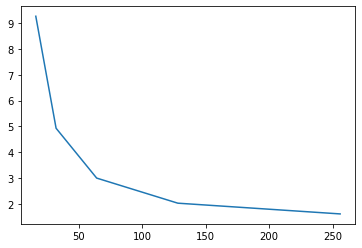

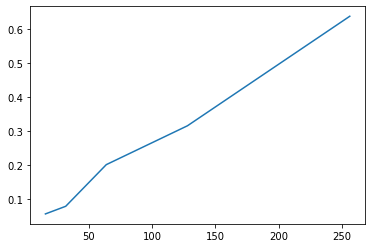

In [32]:
store_loss=[float(a) for a in store_loss]
plt.plot(test_set,store_time)
plt.show()
plt.plot(test_set,store_loss)

0
0.0123786
tensor(0.0124, grad_fn=<MseLossBackward0>)
0.9990428856149671


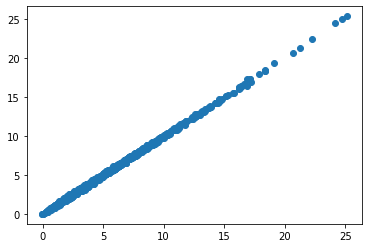

In [7]:
from sklearn.metrics import r2_score,mean_squared_error
start=0
for a,b in val_loader:
    out=model(a)
    print(start)
print(mean_squared_error(out.detach(),b))
b = b.view(-1,1)
print(criterion(out,b))
print(r2_score(out.detach().numpy(),b))
plt.scatter(out.detach().numpy(),b)